In [6]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from skimage.morphology import label
from scipy.ndimage import measurements

In [7]:
# Working through the hooks puzzles.
# Different to #2 as many more limitations on potential hook placements. 24 instead of 3200
# Learned the value of pruning possible solutions!
# - First define valid hook placements
# - For each hook placement determine the cells that are forced by the outside numbers
# - Discard the ones with high numbers to solve (bit of a fudge)
# - Then solve the rest with backtracking

### Puzzle details
<img src="https://www.janestreet.com/puzzles/hook3_puzzle-01.png" width="300" height="300">

In [8]:
#Setup the constraints
top_labels = [0,35,42,18,18,0, 36, 63,0]
bot_labels = [0,40,32,40,10,12,0,56,0]
left_labels = [0,56,0,32,40,15,16,25,0]
right_labels =[0,49,63,0,18,42,63,54,0]
params = [top_labels,bot_labels,left_labels,right_labels]

In [9]:
class Matrix():
    def __init__(self,top_labels,bot_labels,left_labels,right_labels):
        self.top_labels = top_labels
        self.bot_labels = bot_labels
        self.left_labels = left_labels
        self.right_labels = right_labels
        self.potential_grids = [[-9,np.ones((9,9),dtype=int)*-1,[0,0,9,9]]] # list of all grids not yet ruled out.[Level,grid,coordinates of the grid yet to be filled]
        self.solution = []
        self.splits =  [list(i) for i in itertools.product([0, 1], repeat=9) if sum(i) > 1]
     
    ########################################################################################
    # Code to get the initial valid grids

    def add_layer(self,grid,coords,lvl,alignment):
        row_start,col_start,row_end, col_end = coords
    
        if alignment == 0:
            grid[row_start:row_end,col_start] =lvl
            grid[row_start,col_start:col_end] =lvl
            row_start +=1
            col_start +=1
    
        if alignment == 1:
            grid[row_start:row_end,col_start] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            row_end -=1
            col_start +=1 

        if alignment == 2:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_start,col_start:col_end] =lvl
            row_start +=1
            col_end -=1
        
        if alignment == 3:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            row_end -=1
            col_end -=1 
    
        coords = [row_start,col_start,row_end, col_end]
        
        return grid,coords    
   
    def check_grid(self,grid):
        isValid = 1
        for i in range(9):
            row = grid[i,:]
            col = grid[:,i]
            if -1 not in row:
                    isValid *= self.check_line(row,self.left_labels[i],self.right_labels[i])
            if -1 not in col:
                    isValid *= self.check_line(col,self.top_labels[i],self.bot_labels[i])  
        return isValid
                    
    def check_line(self,line,start,end):
        for split in self.splits:
            test = line * split
            if (test[test!=0][:2].prod() == start) or (start ==0):
                if (test[test!=0][-2:].prod() == end) or (end ==0):
                    return 1
        return 0
    
    
#########################################################################################
# Code to get the cells forced to 0 or 1 by the outside constraints
 
    def forced(self,grid,hooks):
        grid[hooks==1] = 1
        changes = 1
    
        while changes >0:
            changes = 0
            for row,col in itertools.product(range(9),range(9)):
                if grid[row,col]==-1:
                # set up the numbers before and after the current grid spot 
                    test =grid*hooks 
                    above = test[:row,col]
                    below = test[row+1:,col]
                    left = test[row,:col]
                    right  =test[row,col+1:]
            
                # work out the befores and afters for each rotation
                    before = [above,below,left,right]   
                    after = [below,above,right,left]
                    avail_after = [[abs(i) for i in j] for j in after]
                    param =[self.top_labels[col],self.bot_labels[col],self.left_labels[row],self.right_labels[row]]
                    count_before = [np.sum(i > 0) for i in before ]
                    num = hooks[row,col]

                #test each rotation
                    for i in range(4):
                        if (param[i] != 0) & (np.sum(before[i] < 0) ==0):
                            if count_before[i] ==0:
                                if param[i] % num  != 0:
                                # if there is nothing before and the current cell does not divide the test number exactly set 0
                                    grid[row,col]= 0
                                    changes +=1
                                elif param[i] / hooks[row,col] not in avail_after[i]:
                                # if there is nothing before and test number/current number is not in the rest of the row set 0
                                    grid[row,col]= 0
                                    changes +=1
                                else:
                                
                                    check_nums_still_avail = False                                
                                    for n in range(len(avail_after[i])): 
                                        if avail_after[i][n] > 0:
                                            if param[i]/avail_after[i][n] in avail_after[i][n+1:]:
                                                check_nums_still_avail = True
                                                break
                                
                                    if not check_nums_still_avail:
                                    #check if the numbers in the rest of the row can still make the test number if not set 1
                                        grid[row,col]= 1
                                        changes +=1
                                      
                                            
                            if count_before[i] ==1:
                                if num != param[i]/np.sum(before[i]):
                                #if a previous number is set and the current number is not the right number to complete the product set 0
                                    grid[row,col] = 0
                                    changes +=1
                                elif (num == param[i]/np.sum(before[i])) & (param[i]/np.sum(before[i]) not in avail_after[i]):
                                # if it is the right number to complete the product and that number is not in the rest of the row set 1
                                    grid[row,col] = 1
                                    changes +=1
                                
                    test[row,col] = 0                        
                    if np.max(label(test!=0,connectivity=1)) > 1:
                    #if placing zero would break connectivity set 1
                        grid[row,col]=1
                                                    
        return(grid)     
    
    
    
                    
#########################################################################################
# Backtracking to solve the rest of the cells
    
    def fill_rest(self,grid,hooks):
        for row,col in itertools.product(range(9),range(9)):
            if grid[row,col]==-1:
                for digit in range(2):
                    if self.possible(digit,row,col,grid,hooks):
                        grid[row,col] = digit
                        self.fill_rest(grid,hooks)
                        grid[row,col] = -1
                return
        sol_print(grid,hooks)
        print("The product of the areas is : {:,.0f}".format(self.areas(grid)))
                                
                            
    def possible(self,digit,row,col,grid,hooks):
        test = grid*hooks
        test[row,col] = hooks[row,col]*digit
    
    #check the placement doesn't break connectivity
        if np.max(label(test!=0,connectivity=1)) > 1:
            return False
    
    #check the placement doesn't exceed the permitted count of that number
        for num in range(2,10):
            if np.sum(test == num) > num:
                   return False
        
    # final checks if the placement completes the grid    
        if np.sum(grid == -1) ==1:
        #check counts again
            for i in range(2,10):
                if np.sum(test == i) != i:
                    return False
    
        #check rows and columns
            for i in range(9):
                row = test[i,:]
                col = test[:,i]
                if (col[col !=0][:2].prod() != self.top_labels[i]) & (self.top_labels[i] !=0):
                    return False
                if (col[col !=0][-2:].prod() != self.bot_labels[i]) & (self.bot_labels[i] !=0):
                    return False
                if (row[row !=0][:2].prod() != self.left_labels[i]) & (left_labels[i] !=0):
                    return False
                if (row[row !=0][-2:].prod() != self.right_labels[i]) & (right_labels[i] !=0):
                    return False   
        return True

#########################################################################################
# Final element


    
    def solve(self):
           
        while len(self.potential_grids) > 0:
            
            temp_grid = self.potential_grids.pop(0)
            #create the potential rotations at the given level
            rotations = []
        
            for alignment in range(4):
                lvl,grid,coords = dcopy(temp_grid)
                grid,coords = self.add_layer(grid,coords,-lvl,alignment)
                if lvl != -1 :
                    rotations.append([lvl+1,grid,coords])
                else:
                     rotations = [[lvl+1,grid,coords]]
    
            
            #check valid grids (where the sum can be made from available digits) and save the ones that work
            for i in range(len(rotations)):
                lvl,g,coords = rotations[i]
                if self.check_grid(g):
                    if lvl !=0:    
                        self.potential_grids.append([lvl,g,coords])
                    else:
                        self.solution.append(g)
                        

        print("There are {} valid hook placements".format(len(self.solution)))
        
        #solve each grid in the cut down list
        forced_grids = []
        for i in range(len(self.solution)):
            #print("Checking: ",i)
            hooks = self.solution[i]
            forced_grid =self.forced(np.ones((9,9))*-1,hooks)
            print("checking #", i)
            print("Cells to solve :",np.sum(forced_grid == -1))
            if np.sum(forced_grid == -1) <24:
                self.fill_rest(forced_grid,hooks)
                #print("Solved")
    
    
    ##############################################
    # Get the products of the areas of the connected cells
    
    def areas(self,grid):
        labels, num = measurements.label(np.logical_not(grid!=0))
        areas = measurements.sum(np.logical_not(grid!=0), labels, index=range(1, num+1))

        return np.prod(areas)
        
#########################
# Code to print in a "nice" format
                            
def sol_print(solved,matrix):
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    x = np.array((solved*matrix).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(matrix,annot=x,cbar=False,cmap="Set3_r",fmt="",linewidths=0.25)
    ax.axis("off")
    
    

There are 24 valid hook placements
checking # 0
Cells to solve : 23
checking # 1
Cells to solve : 12
checking # 2
Cells to solve : 15
checking # 3
Cells to solve : 15
checking # 4
Cells to solve : 17
checking # 5
Cells to solve : 12
checking # 6
Cells to solve : 20
checking # 7
Cells to solve : 14
checking # 8
Cells to solve : 31
checking # 9
Cells to solve : 31
checking # 10
Cells to solve : 31
checking # 11
Cells to solve : 30
checking # 12
Cells to solve : 23
checking # 13
Cells to solve : 23
The product of the areas is : 20,736
checking # 14
Cells to solve : 22
checking # 15
Cells to solve : 22
checking # 16
Cells to solve : 33
checking # 17
Cells to solve : 23
checking # 18
Cells to solve : 34
checking # 19
Cells to solve : 27
checking # 20
Cells to solve : 27
checking # 21
Cells to solve : 27
checking # 22
Cells to solve : 29
checking # 23
Cells to solve : 28

 Solution took 2.8345 seconds



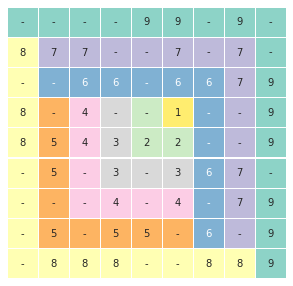

In [10]:
start = time.perf_counter()
test = Matrix(top_labels,bot_labels,left_labels,right_labels)
test.solve()
stop =  time.perf_counter()
print('\n Solution took {:0.4f} seconds\n'.format((stop-start)))


In [12]:
url='https://www.janestreet.com/puzzles/solutions/february-2018-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:9]))

Many solvers were able to find the unique filling of this grid that has all the filled squares connected, and also satisfies the edge product and hook placement conditions. (Shown to the left.) The product of the areas of the regions of empty squares is 20736


### Puzzle solution
<img src="https://www.janestreet.com/puzzles/20180228_hooks_3_ans.png" width="300" height="400">